<a href="https://colab.research.google.com/github/Areeb297/Potential-Talents-Human-Resources-Staffing---Apziva-Project/blob/main/Potential_Talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Project Summary**

A talent sourcing and management company requires automating the process of identifying and ranking the best candidates for various roles where the current manual process is challenging and labor-intensive. The key challenges the company faces are:

1. Understanding the role: Accurately interpreting client's needs and expectations for potential candidates

2. Evaluating Candidates: Determining what makes a candidate suitable for a given role.

3. Sourcing talent: Finding qualified individuals from a large pool of candidates.

To address, the aim of this project is to develop a ML-powered pipeline that automates candidate ranking based on their "fitness" for a specific role. Additionally, this system should adaptively re-rank candidates based on the human reviewer initial seletion such that the model re-ranks the list to better align with the reviewer's preferences, considering the starred candidate as the most important for this particular role. This will imporove the rankings generated by system over time.

#### **Key Requirements:**

* Fitness prediction
* Ranking
* Re-ranking
* Mitigate Human Bias in the process
* Filtering

### **Data Description:**

The dataset contains anonymized candidate information sourced through the company's semi-automated process and sourcing efforts.

Attributes:

1. id: Unique numeric identifier for each candidate
2. job_title: Text description of the candidate's job title.
3. location: Geographical location of the candidate.
4. connections: Number of professional connections the candidate has (e.g., 500+ indicates more than 500 connections).
5. fit: Target variable indicating the candidate's fitness score (numeric probability between 0 and 1). We can use cosine-similarity for this.

Currently, the fit column is empty so we need to employ NLP techniques such as TF-IDF, Word2Vec, Bert, Open source LLMs etc to match our search with job_title, location, and connections (the more the connections, the better it is as it is considered an added benefit).

### **Keywords:**
The data is based on searching specifc keywords for roles:
1. Aspiring human resources
2. Seeking human resources

### **Goals & Objective:**
1. Build a predictive model to calculate fitness score for each candidate based on given query.
2. Use fitness scores to rank candidates for specific roles.
3. Enable re-ranking based on manual feedback (starring action).
4. Identify methods to filter out candidates which in the first place should not be in this list?
5. Define an adaptive cut-off point that would work for other roles to exclude low-potential candidates while retaining high-potential ones.


The objective is to develop an intelligent candidate ranking system to ensure best and most talented candidates are selected to technology companies using NLP techniques such as TF-IDF, Cosine Similarity, Word2Vec, Transformer-Based Models and leveraging open source LLMs with frameworks like LangChain to automate aspects of candidate evaluation process.


### Import Relevant Libaries

In [2]:
!pip install nltk

In [3]:
from google.colab import drive
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

**Picking a Random Seed**

In [4]:
# Mount google drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Apziva AI Residency/Project 3"
os.chdir(project_path)

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Apziva AI Residency/Project 3


In [5]:
# Pick a random seed

# np.random.randint(0, 20000)

In [6]:
# Pick a random seed
random_seed = 16166 # We use this random seed as after 100 iterations of using LazyClassifier, this gives best results.
print(f"Using random seed: {random_seed}")

# Set the random seed across different libraries
random.seed(random_seed)
np.random.seed(random_seed)

Using random seed: 16166


#### Loading & Cleaning Data

In [7]:
import pandas as pd

df = pd.read_csv('potential-talents.csv')

In [8]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [10]:
df.describe(include='object')

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


It looks as though the spelling of Kanada is incorrect, let us change that.
Additionally, there seems to be null data in the three columns, job_title, location, and connection.

Lastly, id column seems redundant, as the index column is present already, will remove that as well.

In [11]:
# Correct the spelling of Canada
df['location'] = df['location'].replace('Kanada', 'Canada')

# Remove the id column as not required
df.drop('id', axis=1, inplace=True)

We need a way to sort the data based on connections but connection is in object
format. Let us convert it to numerical and the value for 500+ can be used.

We will map the 500+ to 501 numerically and create a new column called
connection_numeric.

In [12]:
df.head()

,job_title,location,connection,fit
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [13]:
# Function to convert connections to numerical values
def convert_connections(value):
    if value == '500+ ':
        return 501  # Use a number slightly higher than 500 for sorting
    else:
        return int(value)

# Apply the function to the connections column
df['connections_numeric'] = df['connection'].apply(convert_connections)

In [14]:
df.sort_values('connections_numeric', ascending=False).head(10)

,job_title,location,connection,fit,connections_numeric
52,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,501
58,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
34,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501
37,HR Senior Specialist,San Francisco Bay Area,500+,NaN,501
39,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,501
41,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN,501
42,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,NaN,501
44,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501
46,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
47,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501


## Exploratory Data Analysis

Let us visualize what the distribution of number of connections looks like in our talent pool sourced for HR positions


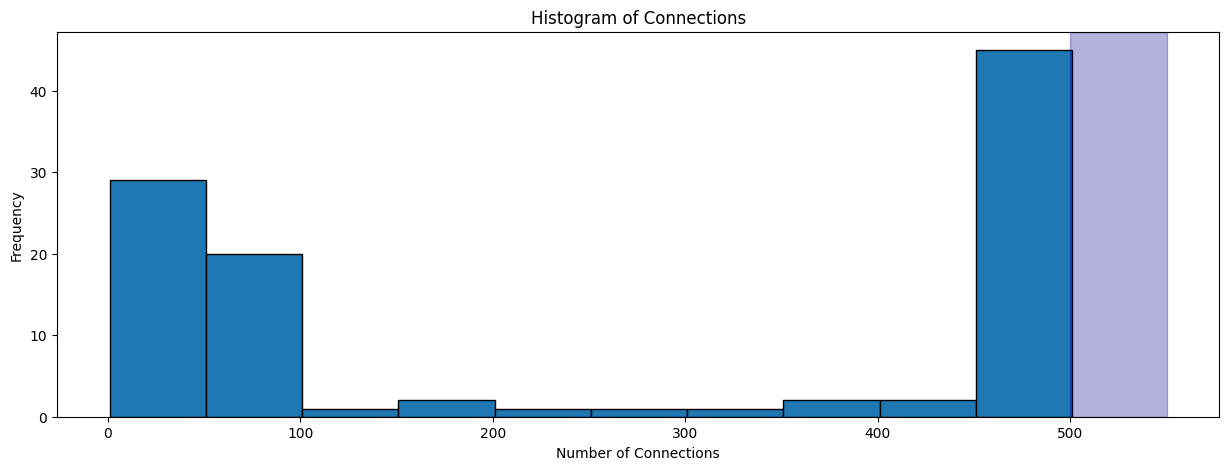

In [15]:
# Plotting the histogram
plt.figure(figsize=(15, 5))  # Optional: Adjust the figure size for better visibility
plt.hist(df['connections_numeric'], bins=10, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Connections')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')

plt.axvspan(500, 550, color='darkblue', alpha=0.3, label='Connections > 500')

# Display the plot
plt.show()


We see that majority of the candidates have connections more than 500+ connections on LinkedIn and the second highest category is the group with connections less than 100 (in opposite ends).

In [16]:
# Let us see which locations seem to be the most popular in our results.
df.connection.value_counts().head(15)

,count
connection,
500+,44
85,7
61,7
44,6
1,5
2,4
4,2
7,2
57,2


In [17]:
# Let us see which locations seem to be the most popular in our results.
df.location.value_counts().head(15)

,count
location,
Canada,12
"Raleigh-Durham, North Carolina Area",8
"Houston, Texas Area",8
Greater New York City Area,7
"Houston, Texas",7
"Denton, Texas",6
San Francisco Bay Area,5
Greater Philadelphia Area,5
"İzmir, Türkiye",4


It seems majority of the search results are employees from Canada,
North Carolina, Houston, New York etc. But we do see that there
are some potential duplicates like Texas Area and Texas.

After further research, there is a difference between the two as
Houston, Texas for example refers specifically to the city of Houston
whereas Houston, Texas Area encompasses not only the city of Houston
but also the surrounding metropolitan area. So we can leave it as it is.

#### Visualize the data (job titles) in a word cloud.

For that, firstly let us remove Stop Words using nltk library

In [18]:
# Download the stopwords dataset
nltk.download('stopwords')

nltk.download('punkt')  # Necessary for word_tokenize
# It is a pre-trained tokenizer model in NLTK
# word_tokenize uses punkt model to intelligently handle punctuations, contractions,
# and special cases.

# Without punkt, the information to handle punctuation, contractions, and special
# cases will not be there for word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
import nltk
import string
nltk.download('punkt')  # Downloads the punkt tokenizer resource
nltk.download('stopwords')  # Downloads the stopwords list
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Using string libary, stopwords, punkt etc., we remove stopwords such as the, and, and additionally common punctuation marks like brackets, quotation marks, full stops etc.

In [20]:
# Function to remove stop words from text and convert text to lowercase
# for consistency

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
    return ' '.join(filtered_words)


# Apply the function to remove stop words but keep the original job_title column
df['job_title_cleaned'] = df['job_title'].apply(remove_stop_words).str.lower()

In [21]:
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t bauer college business graduate magna...
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik english program korea
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university


In the above, we can now also use connections_numeric to sort the most talented candidates.

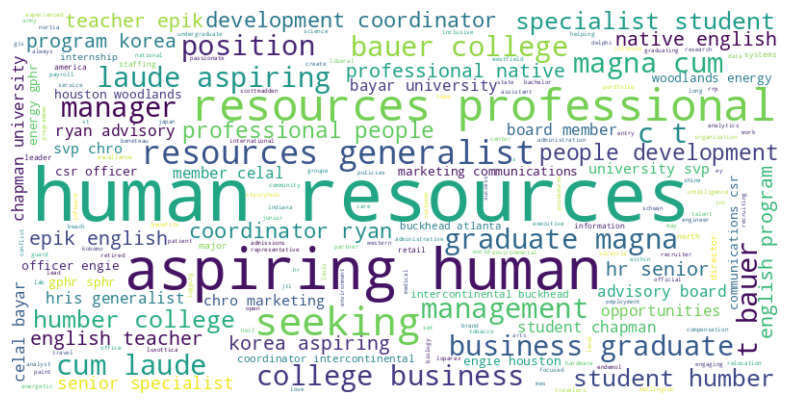

In [22]:
# Visualize the new column as a word cloud
# Combine all job titles into a single string
text = ' '.join(df['job_title_cleaned'])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axes
plt.show()

It looks as the Word Cloud visualization highlights key terms such as "aspiring", "manager", "human resources" etc., are the most frequently occuring words. This aligns with what the initial keywords were ("Aspiring human resources" & "seeking human resources"). However, some words like "magna", "laude", "epik" appear which are associated with university honours or institution names.

While these reflect academic achievements or affiliations, they may not be directly relevant to identifying the most talented candidates purely based on their professional capabilities. University reputation or a business degree from college could play an important role in candidate evaluation however not all rows or job titles given contain that information. Thus, filtering based on these solely might overlook other strong contenders who have identified themselves as "aspiring HR professionals". But based on what the user searches, these terms will be helpful in distinguishing the requested candidates using cosine similarity etc.

### TF-IDF (Term Frequency-Inverse Document Frequency)

This is a statistical technique used to evaluate the importance of a word in a document relative to a collection of documents (or a corpus).

TF = # Times the term appears in document / # Terms in the document

IDF = Log (Total Documents / Number of Documents containing the term)

Tf-IDF = Tf x IDF

This helps to assign a weight to each term and highlight words that are meaningful and relevant for a given document. This can help to identify the most significant words in candidates' job titles or descriptions.

The above will calculate TF-IDF score for each word based on:
1. How frequent the word is in the specific sentence or document
2. How rare the word is across the entire dataset.

The first step would be to tokenize the text however with TF-IDF libraries such as TfidfVectorizer from sklearn, this is automatically handled for us.

For each job title, we will calculate the TF-IDF vector and then afterward, represent each job title as its corresponding vector in the matrix. We will store that as a new column in our dataframe e.g., df['job_title_vectorized]'

We also require location enabled search so we will combine job_title & location into a single column, compute TF-IDF, and then use that for similarity calculation.

In [23]:
# Clean the location column

df['location_cleaned'] = df['location'].str.lower().str.replace('[^\w\s]', '', regex=True)

# Combine job_title and location into a single column

df['combined_text'] = df['job_title'] + " " + df['location_cleaned']


# Initialize a new TfidfVectorizer for combined text
tfidf_vectorizer_combined = TfidfVectorizer()
tfidf_matrix_combined = tfidf_vectorizer_combined.fit_transform(df['combined_text'])

# Convert the TF-IDF matrices to lists for DataFrame storage
tfidf_values_job_title_location = tfidf_matrix_combined.toarray().tolist()


# Add new columns to store TF-IDF values
df['tfidf_values_combined'] = tfidf_values_job_title_location

# Display the DataFrame with the new columns
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t bauer college business graduate magna...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik english program korea,canada,Native English Teacher at EPIK (English Progra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university,izmir türkiye,Advisory Board Member at Celal Bayar Universit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Cosine Similarity

Cosine Similarity is a metric used to measure similarity between two vectors by calculating the cosine of the angle between them in high-dimensional space.

Cosine Similarity Values Range from:
* +1 - Perfectly Similar
* 0 - No similarity
* -1 - Perfectly dissimilar.

Formula:

Cosine Similarity = A . B / ||A|| ||B||

It is used for text & document similarity as it measures the degree of similarity between text vectors helping in ranking, clustering, and matching text data. It is also computationally efficient & works well with sparse data.



Now that we have vectorized our job_title_location combined column, let us convert our query to a vector, then use cosine similarity and use the connections_numeric column to get the most relevant results. We will populate the 'fit' column with our cosine similarity values.

In [24]:

# Define functions that can tokenize & vectorize the query,
# perform cosine similarity, and output the relevant results.


# Additionally, at the end, will also sort the results by number of connections
# in descending order as we would prefer someone well connected and talented.

# Preprocess the query (e.g., lowercase, remove stop words)
def preprocess_query(query):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word.lower() for word in word_tokenize(query) if word.lower() not in stop_words])


# Function to process query, compute cosine similarity, and return top results
def get_top_matches(query, tfidf_vectorizer, tfidf_matrix_combined, df, top_n=10):
    # Preprocess the query
    query_cleaned = preprocess_query(query)

    # Transform the query into vectors for both job_title and location
    query_vector_combined = tfidf_vectorizer.transform([query_cleaned])


    # Compute cosine similarity between the query vector and all job titles
    similarity_scores = cosine_similarity(query_vector_combined, tfidf_matrix_combined).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                    job_title  \
7                        HR Senior Specialist   
25                       HR Senior Specialist   
37                       HR Senior Specialist   
50                       HR Senior Specialist   
60                       HR Senior Specialist   
82  HR Manager at Endemol Shine North America   
2       Aspiring Human Resources Professional   
16      Aspiring Human Resources Professional   
20      Aspiring Human Resources Professional   
32      Aspiring Human Resources Professional   

                               location connection       fit  
7                San Francisco Bay Area      500+   0.353966  
25               San Francisco Bay Area      500+   0.353966  
37               San Francisco Bay Area      500+   0.353966  
50               San Francisco Bay Area      500+   0.353966  
60               San Francisco Bay Area      500+   0.353966  
82    

**Observations:** The above works correctly when the query is very specific however, it cannot recognize HR being Human Resources so when I query Aspiring HR, it returns HR Specialist as a top result but when I write the whole words, the result works as expected. Context cannot be recognized from generated word embeddings by Tf-IDF, with transformer based approaches, this problem is solved



1.   The above is a common limitation of the TF-IDF approach in its ability to recognize that abbreviations like HR correspond to Human Resources. This occurs due to the fact that TF-IDF treats each term as distinct and lacks the semantic understanding to link abbreviations to their full forms.
2.   Term Independence results in TF-IDF not understanding relationships between terms & their contextual usage.

To solve this, we can use Word Embeddings models such as Word2Vec, GloVe to generate dense vector representation of words, capturing semantic relationships.

Additionally, transformer-based models like BERT can understand context better and capture meanings of phrases and abbreviations within their usage.


#### Re-rank candidates when a candidate is starred

After the user "stars" or selects a candidate, they signal that this candidate is an **ideal match** therefore, the system can use this supervisory signal to adjust the ranking, prioritizing candidates that are similar to the starred candidate. This re-ranking process ensures that future results will reflect the qualities of the starred candidate.

To implement this re-ranking mechanism, we perform initial search as usual, once a user stars a candidate, we can treat this candidate's TF-IDF or semantic embedding as a new benchmark. Using this vector, we compute cosine similarity between the starred candidate's vector and all other candidate's vectors.

Then, we re-rank the list based on the new similarity scores and display the updated list to the user.

Below is the updated implementation of searhing relevant candidates now incorporating re-ranking functionality.

In [ ]:
def rerank_candidates(starred_vector, tfidf_matrix, df):
    """Re-rank candidates based on similarity to the starred candidate."""
    # Compute cosine similarity between starred vector and all others
    similarities = cosine_similarity(starred_vector, tfidf_matrix).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarities

    # Sort by similarity score in descending order
    df_sorted = df.sort_values(by='fit', ascending=False)

    # Return the re-ranked DataFrame
    return df_sorted[['job_title', 'location', 'fit']]


while True:
    # Get user input
    query = input("Enter your search query (or type 'exit' to quit): ").strip()
    if query.lower() == 'exit':
        print("Exiting the search.")
        break

    # Call the function to get top matches
    top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

    # Display the top results
    print("\nTop Matches:")
    print(top_results)

    while True:
        try:
            # Ask user to star a candidate from the displayed results
            star_input = input("\nEnter the index of the candidate you want to star (or type 'back' to perform another search): ").strip()
            if star_input.lower() == 'back':
                print("Returning to search...")
                break

            # Convert the input to an integer (index in the DataFrame)
            star_index = int(star_input)

            if star_index < 0 or star_index >= len(top_results):
                print(f"Invalid index. Please select an index between 0 and {len(top_results) - 1}.")
                continue

            # Get the vector of the starred candidate
            starred_vector = tfidf_matrix_combined[top_results.index[star_index]]

            # Re-rank the candidates based on similarity to the starred candidate
            re_ranked_results = rerank_candidates(starred_vector, tfidf_matrix_combined, df)

            # Display the re-ranked results
            print("\nRe-Ranked Results Based on Your Starred Candidate:")
            print(re_ranked_results.head(10))  # Show top 10 results after re-ranking
        except ValueError:
            print("Invalid input. Please enter a valid index or 'back' to perform another search.")

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                    job_title  \
7                        HR Senior Specialist   
25                       HR Senior Specialist   
37                       HR Senior Specialist   
50                       HR Senior Specialist   
60                       HR Senior Specialist   
82  HR Manager at Endemol Shine North America   
2       Aspiring Human Resources Professional   
16      Aspiring Human Resources Professional   
20      Aspiring Human Resources Professional   
32      Aspiring Human Resources Professional   

                               location connection       fit  
7                San Francisco Bay Area      500+   0.353966  
25               San Francisco Bay Area      500+   0.353966  
37               San Francisco Bay Area      500+   0.353966  
50               San Francisco Bay Area      500+   0.353966  
60               San Francisco Bay Area      500+   0.353966  
82    

The above works as expected where once I selected the 3rd candidate where the location was North Carolina, in my updated re-ranked list, all top candidates with the same job title keywords and location show up as the top results, thus having 100% fit as shown.

Now the next step will be to experiment with other vector embedding techniques such as Word2Vec, BERT, and additionally open-source LLMs.

### Word2Vec

Word2Vec is a neural network based approach in NLP where it transforms words into continuous vector representations, and is able to capture meanings based on given context unlike TF-IDF. It was developed by a team at Google in 2013, we can use it to better understand semantic relationships between words.

Word2Vec employs 2 main methods: Continuous Bag of Words (CBOW) and Skip-Gram. Both models are trained on large text corpora in high-dimensional vector space.

When it comees to **CBOW, it predicts a word based on the words around it. This is fast**, and works well for common words. The context is defined a pre-defined window size which determines how many words before and after the target word are considered. The average vector that is calculated is passed through a small neural network where the word with the highest probability is predicted as the target word. CBOW does not care about the word order, it learns word relationships by adjusting the word vectors during training so that the average vector matches the target word.

Concerning <u>**Skip-Gram, the idea is to predict context words from the target, it essentially works the other way around.** For each target word, the model uses it to predict the context words within the same window size, this method is **slow but more precise**</u> as it is useful for learning high quality word vectors for rare words. **Skip-Gram uses negative sampling** which updates only a small number of weights instead of all vocabulary words, it picks a few negative words and ensures the model assigns low probabilities to them.

<u>Key Differences between CBOW & Skip-Gram</u>

Prediction Direction:

*   CBOW predicts the target word from context words
*   Skip-Gram predicts context words from the target word.

Training Speed:


*   CBOW trains faster due to its averaging approach of taking the average of the vectors of context words within a pre-defined window size around the target words.
*   Skip-Gram trains slower but captures more detailed word relationships, it works by assigning higher weights to nearby context words, capturing the order and distance of words in the context.



Performance with Rare Words:



*   CBOW may not perform as well with infrequent words
*   Excels at learning representations for rare words as the model learns representation of words by analyzing contexts in which they occur. By focusing on predicting context words, Skip-Gram captures the relationships between a rare word and its neighboring words.




<u>***Comparison between TF-IDF & Word2Vec:***</u>

TF-IDF is a statistical measure that evaluates the importance of word in a document relative to collection of documents focusing on term frequency & inverse document frequency. Thus, it cannot capture the semantic understanding between words, as it treats each word independently.

Word2Vec on the other hand, captures semantic and syntactic relationships by learning from word contexts in the corpus, producing dense, continuous vector representations where similar words have similar vectors enabling the model to understand relationships such as king -> man etc.





1.   First thing would be to use gensim library to train a Word2Vec Model (Skip Gram) on tokenized text.
2.   We use the sane process as we did for TF-IDF, where we use cosine similarity to retrieve top matches.



In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)

# Step 3: Training a Word2Vec Model (CBOW)
# sentences=df['tokenized_text']: The input text in tokenized form.
# vector_size=1000: Sets the dimensionality of the word vectors to 1000.
# window=10: Defines the maximum distance between the current and predicted words within a sentence.
# min_count=5: Ignores words that appear fewer than 5 times in the corpus.
# sg=1: Specifies the Skip-Gram architecture (sg=0 would use CBOW).
# Parameters: sg=1 for Skip Gram, vector_size=1000 for 1000-dimensional embeddings, window=5 for context window size
# This will create word embeddings from scratch based on the existing dataset only

word2vec_model = Word2Vec(sentences=df['tokenized_text'], vector_size=1000,
                          window=10, min_count=5, sg=1)

# Step 4: Vectorize Each Combined Text
def vectorize_text(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average the vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the vocabulary

df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, word2vec_model))

# Step 5: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 6: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined,tokenized_text,word_2_vec_vectorized_text
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.000000,85,2019 c.t bauer college business graduate magna...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2019, C.T, ., Bauer, College, of, Business, G...","[0.0005712246, -4.6617082e-05, 3.0801115e-05, ..."
1,Native English Teacher at EPIK (English Progra...,Canada,500+,0.000000,501,native english teacher epik english program korea,canada,Native English Teacher at EPIK (English Progra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Native, English, Teacher, at, EPIK, (, Englis...","[0.0009205316, -5.284237e-06, 0.00026724508, 0..."
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.045753,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Aspiring, Human, Resources, Professional, ral...","[0.00037337656, 4.749037e-05, 0.00047289755, 0..."
3,People Development Coordinator at Ryan,"Denton, Texas",500+,0.000000,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[People, Development, Coordinator, at, Ryan, d...","[-7.5180214e-05, 0.00039820303, 0.00011832981,..."
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,0.000000,501,advisory board member celal bayar university,izmir türkiye,Advisory Board Member at Celal Bayar Universit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Advisory, Board, Member, at, Celal, Bayar, Un...","[-4.3756227e-05, 1.6082049e-06, 0.0002897377, ..."


In [ ]:
# Provides an interactive way to search for matches by continuously
# accepting user queries and displaying the top results.

while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, word2vec_model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title            location  \
65  Experienced Retail Manager and aspiring Human ...  Austin, Texas Area   
0   2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
14  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
18  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
30  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
43  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
56  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
6   Student at Humber College and Aspiring Human R...              Canada   
8   Student at Humber College and Aspiring Human R...              Canada   

   connection       fit  
65         57  0.564380  
0          85  0.523912 

It seems the performance is quite poor when using Word2Vec for SkipGram, additionally, even if we experiment with CBOW, the performance is still nearly the same. This is becasue our dataset is relatively small, we require using a pre-trained Word2Vec model to get better performance. A few hundred rows to train a Word2Vec model results in poor accuracy Word2Vec requires a large corpus of data to generate meaningful embeddings as there is limited vocabulary and many words not appearing frequently may not be enough to establish strong relationships.


Now to solve this, we can use a pre-trained Word2Vec model such as the Google News model, can download it & load it into gensim.

The Google News Dataset is a widely used pre-trained Word2Vec model containing 3 million words & phrases with 300-dimensional vectors. We will use a slimmed down version of that model which contains only 300k words which will save us time when loading the model.

https://github.com/eyaler/word2vec-slim/tree/master

In [ ]:
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model
model_path = 'GoogleNews-vectors-negative300-SLIM.bin'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, word2vec_model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title            location  \
65  Experienced Retail Manager and aspiring Human ...  Austin, Texas Area   
0   2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
14  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
18  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
30  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
43  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
56  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
6   Student at Humber College and Aspiring Human R...              Canada   
8   Student at Humber College and Aspiring Human R...              Canada   

   connection       fit  
65         57  0.564380  
0          85  0.523912 

It seems even the pre-trained Word2Vec model did not perform well.
Same errors ocurring such as not recognizing HR and not returning the correct results even though it was trained on 300k words. Word2Vec seems as though it struggles with limited datasets due to its need for a large corpus to establish meaningful word relationships, hence we would require using the model trained on 3M words to get meaningful results.

As in Goolge colab, there is insufficient disk space to run this mode, we will skip this step but below is the code the load the pre-trained model.

In [ ]:
# import gensim.downloader as api

# # Load the pre-trained Word2Vec model 3M words model
# model = api.load("word2vec-google-news-300")

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

### Glove Model



GloVe (Global Vectors for Word Representation) is an unsupervised algorithm that generates word embeddings by analyzing global word-word co-occurence statistics within a corpus. It captures frequencey with which words appear together, so in effect it allows distances to reflect semantic relationships. Developed by researchers at Stanford, GloVe uses matrix factorization to create word vectors that capture their meanings using a count-based method to find patterns in word co-occurence. It basically creates similar vectors or words with similar meaning using a weighted least squares model.

GloVe helps in understanding global word relationships in the dataset, Word2Vec on the otherhand is better for detailed relationships between nearby words.

We will use pre-trained GloVe Embeddings and test on dataset.

In [ ]:
import gensim.downloader as api

# Load the pre-trained GloVe Twitter model with 25-dimensional vectors
# This model has been trained on a vast corpus of Twitter data, specifically 2B Tweets. Lower vocab size.
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# Showcase how to search for synonyms
# Access the vector for a specific word
# word_vector = model['example']

# Find the most similar words
similar_words = model.most_similar('car')
similar_words

[('front', 0.9365070462226868),
 ('on', 0.9070020914077759),
 ('table', 0.8939011693000793),
 ('truck', 0.8898833394050598),
 ('place', 0.8800072073936462),
 ('foot', 0.876794159412384),
 ('bus', 0.8759488463401794),
 ('train', 0.875607967376709),
 ('pull', 0.8720093369483948),
 ('seat', 0.866832971572876)]

In [ ]:
def vectorize_text(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, model))

# Step 5: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 6: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title  \
26  Aspiring Human Resources Management student se...   
28  Aspiring Human Resources Management student se...   
75  Aspiring Human Resources Professional | Passio...   
83  Human Resources professional for the world lea...   
65  Experienced Retail Manager and aspiring Human ...   
91  Seeking employment opportunities within Custom...   
88                    Director Human Resources  at EY   
89  Undergraduate Research Assistant at Styczynski...   
72  Aspiring Human Resources Manager, seeking inte...   
5                 Aspiring Human Resources Specialist   

                      location connection       fit  
26         Houston, Texas Area      500+   0.806521  
28         Houston, Texas Area      500+   0.806521  
75          New York, New York        212  0.759876  
83        Highland, California         50  0.740344  
65          Austin, Texas 

When using GloVe embeddings, the performance shows significant improvement compared to not using a pre-trained model. GloVe's pre-trained embeddings, trained on vast corpora, excel in capturing semantic nuances. Even with a small dataset, GloVe performs well, effectively recognizing context-specific terms better than TF-IDF.


Since GloVe is a count-based model as it constructs global word-word co-occurence matrix, it can capture meaningful word relationships even in smaller datasets. This model is more suitable for tasks with limited data.

### FastText

FastText is an open-source library (by Facebook's AI Research Lab) for efficient learning of word representations & text classification. FastText represents each word as a bag of character n-grams, this way it can generate embeddings for words not seen during training.

It is designed for speed & can handle large datasets efficiently. So this creats embeddings by considering subword (character n-gram) information, thus allowing it to capture internal word structures. This helps FastText handle Out-of-Vocabulary (OOV) words by constructing their embeddings from constituent character n-grams.

E.g., artificial with n=3 is represented by: ar, art, rti, tif, ifi, fic, ici, ial, al

FastText essentially enhances Word2Vec by representing each word as a combination of character n-grams, thus it can generate embeddings for words by summing the vectors of their n-grams. FastText's use of its subword compositions allows it to capture morphological variations and similarities between words that Word2Vec may miss due to its word-level focus. Bysumming the vectors of these n-grams, FastText captures the internal structure of words, it creates a composite vector that reflects the meaning of the entire word.


In [ ]:
!pip install gensim
!pip install compress-fasttext


In [ ]:
import os
os.listdir()

['Portential Talents.ipynb',
 'GoogleNews-vectors-negative300-SLIM.bin',
 'potential-talents.csv',
 'cc.en.300.bin']

In [ ]:
# from gensim.models.fasttext import load_facebook_model

# # Load the pruned FastText model
# model = load_facebook_model('cc.en.300.bin')


# Unfortunately, we encounter memory / RAM issues when attempting to load large
# pre-trained FastText models in Google Colab. Hence, we will be skipping this part
# code execution.

# We will be using Gensim downloader, and load a FastText model trained on
# Wikipedia

# These models are often more memory-efficient and can be loaded directly
# without the need for manual downloading or pruning.

# This model has 300-dimensional vectors and includes subword information,
# making it both comprehensive and efficient.

import gensim.downloader as api

# Load the pre-trained FastText model
model = api.load('fasttext-wiki-news-subwords-300')

# This means the embeddings can understand & represent
# words based on their internal character n-grams, enhancing model's ability to
# deal with complex word forms and previously unseen words.




[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def vectorize_text(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, model))

# Step 3: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 4: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title                location  \
81  Aspiring Human Resources Professional | An ene...      Austin, Texas Area   
75  Aspiring Human Resources Professional | Passio...      New York, New York   
74  Nortia Staffing is seeking Human Resources, Pa...    San Jose, California   
7                                HR Senior Specialist  San Francisco Bay Area   
25                               HR Senior Specialist  San Francisco Bay Area   
37                               HR Senior Specialist  San Francisco Bay Area   
50                               HR Senior Specialist  San Francisco Bay Area   
60                               HR Senior Specialist  San Francisco Bay Area   
0   2019 C.T. Bauer College of Business Graduate (...          Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...          Houston, Texas   

   connection       fit  
81    

FastText performs comparably to GloVe in many scenarios; however, both models face limitations in accurately interpreting domain-specific terms, such as recognizing "HR" as "Human Resources." This challenge arises from the need for additional training on specialized vocabulary and contextual understanding tailored to the model's application. While both FastText and GloVe generally outperform Word2Vec, they can sometimes struggle with nuanced contexts, particularly when dealing with combinations of locations and job titles e.g., HR in Canada for example.

### Bert based embeddings
### Transformer models

These types of models differ significantly from earlier word embedding methods such as Word2Vec & GloVe, both in functionality and the way embeddings are genertated.

1.   Word2Vec & GloVe generate static embeddings, assigning each word a single vector representation during their training process. But they generate static embeddings that do not change based on context during inference process. Here, embeddings are context-indepedent so a word like "bank" will always have the same vector representation (known as Polysemy). Word2Vec is focused on predicting nearby words whereas Glove maninly is capturing co-occurrence statistics.

2.   Transformer based models such as BERT or GPT generate dynamic embeddings that adapt to specific context of each word's usage. These use deep neural networks that uses attention mechanism to understand relationships between words in a sentence. These models can effectively distinguish between different meanings of the same word based on context.

Thus, transformer models are capable of understanding complex linguistic relationships such as syntax & semantics, it can handle token, sentence & document level tasks with fine-tuning.

The attention mechanism in transformers allows to dynamically adjust word representations based on context. Each word is represented by three vectors: Query, Key & Value. The mechanism first computes the similarity between its Query vector & Key vectors of all words in a sequence. This determines the relevance of other words to the current word.

Computed similarities are then normalized to produce attention weights, indicating importance of each word in understanding the current word. The model generates a new representation for the current word by summing the value vectors of all words.



**BERT**

Bidirectional Encoder Representations:

This method employs the transformer architecture using self-attention to process words in relation to their surrounding words in both directions. This bi-directional approach allows BERT to capture the full context of a word generating context-aware embeddings where representation of each word is influenced by the entire sentence, leading to a more nuanced language understanding.




In [27]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import pandas as pd

# Load pre-trained BERT model and tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Function to get BERT embeddings for a sentence
def vectorize_text_with_bert(tokens, model, tokenizer):
    # Tokenize and encode the text
    inputs = tokenizer(" ".join(tokens), return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model output
    # .no_grad(): Tells PyTorch we don't need gradients (saves memory)
    # Runs the text through BERT
    # Gets back rich representations for each token
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the sentence embedding
    # Takes BERT's final layer output, averages all token representations
    # Returns a singel vector representing the entire text.
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


# Step 2: Tokenize and Vectorize Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['bert_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text_with_bert(x, model, tokenizer))

# Step 3: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query_with_bert(query, model, tokenizer):
    tokens = [word.lower() for word in word_tokenize(query) if word.isalnum()]
    return vectorize_text_with_bert(tokens, model, tokenizer)

# Step 4: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_bert(query, model, tokenizer, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query_with_bert(query, model, tokenizer)

    # Compute cosine similarity
    similarity_scores = df['bert_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit', 'bert_vectorized_text']].head(top_n)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Interactive search loop
while True:
    # Get user input
    query = input("Enter your search query (or type 'exit' to quit): ").strip()
    if query.lower() == 'exit':
        print("Exiting the search.")
        break

    # Call the function to get top matches
    top_results = get_top_matches_with_bert(query, model, tokenizer, df)

    # Display the top results
    print("\nTop Matches:")
    print(top_results)


Enter your search query (or type 'exit' to quit): HR in Turkiye

Top Matches:
                                            job_title  \
4     Advisory Board Member at Celal Bayar University   
22    Advisory Board Member at Celal Bayar University   
34    Advisory Board Member at Celal Bayar University   
47    Advisory Board Member at Celal Bayar University   
93  Seeking Human  Resources Opportunities. Open t...   
77             Human Resources Generalist at Schwan's   
97                                            Student   
3              People Development Coordinator at Ryan   
17             People Development Coordinator at Ryan   
21             People Development Coordinator at Ryan   

                       location connection       fit  
4                İzmir, Türkiye      500+   0.780503  
22               İzmir, Türkiye      500+   0.780503  
34               İzmir, Türkiye      500+   0.780503  
47               İzmir, Türkiye      500+   0.780503  
93  Amerika Birleşi

### Implementing Learning To Rank Systems

**Learning to Rank (LTR) is a ML approac**h utilizing NLP to train models simply for ranking systems based on their relevance to a query, although some methods rank items independently of the query, relying on intrinsic features like text length or item ratings.

Other approaches take query-specific features, such as how frequently a query term appears in a document. These approaches allow system to adapt to diverse ranking context based on user requirements, whether general or query-dependent.

When training an LTR model, we have 3 core methodologies used:


1.   **Pointwise Methods:** Treat as a standard ML task by predicting relevance score for each item independently, evaluating them row by row.
2.   **Pairwise Methods:** Focus on predicting relative order between pairs of items where we are simultaneously comparing two items at a time & deciding which one should be ranked first. The system learns how to compare to create a full, ranked list that's accurate & consistent.
3.   **Listwise Methods:** This approach optimizes the ranking of an entire list by directly aligning the list with user-defined ranking standards. Simply put, listwise methods take an entire list of items and learns how to sort them in the best order based on examples of already sorted lists.

**Evaluation:**

LTR Models involve measuring effectiveness in producing accurate rankings. Common evaluation metrics include:


*   Mean Average Precision (MAP): Calculates precision of model's top-ranked items & evaluates binary relevance judgements based on the training set.

Here precision is used to evaluate the metric of the retrieval system where it is defined as:

\begin{equation}
\text{Precision} = \frac{\text{Number of Relevant Documents Retrieved}}{\text{Number of Total Documents Retrieved}}
\end{equation}

Basically, the above measures how many items returned by the system are actually relevant, providing insight into the system's ability to filter out irrelevant information. Basically for each query, the system calculates the average precision considering precision at various cutoff points (relevant documents received) & then provides a single-figure measure of quality across a set of queries.

*   Discounted Cumulative Gain (DCG):

In this algorithm, we simply start off with a ranked list of items by the model. Each item gets assigned a relevance score based on how useful it is. Then we reduce the impact of lower-ranked items through applying discount factor:

\begin{equation}
\text{DCG}_p = \sum_{i=1}^p \frac{\text{rel}_i}{\log_2(i+1)}
\end{equation}

We calculate DCG by adding relevance scores, comparing DCG score with best possible ranking called the ideal DCG i.e., IDCG. To facilitate comparison, DCF, we normalize the score so the final metric we are trying to maximize is the NDCG score calculated as:

\begin{equation}
\text{NDCG}_p\ = \frac{\text{DCG}_p}{\text{IDCG}_p}
\end{equation}



Key Steps with implementing LTR:



1.   Documents
2.   User / Search Query
3.   Top-K Retrieval
4.   Ranking Model
5.   Results page


After initial Top-K retrieval to get top K documents for the query, we can extract top-K features, then pass the features through a trained LTR model to get the final ranking. Usually, apply initial retrieval for top-K documents first, then apply LTR.





We will be using RankNet for LTR, it is a pairwise ranking model that takes in pairs of data points as inputs & predicts probability of one input ranking higher than the other. It will learn to compare two documents and decide which one is better. It takes the documents features, passing through neural network layers, then outputs a single score for each document.

It essentially calculates the probability score that doc1 > doc2 using signmoid (s1-s2). When using for search:

*   We get initial results using cosine similarity
*   For top results, we compare each pair.
*   Count how many times each document "wins" comparisons.
*   Final ranking based on win counts.






Our requirement is to re-rank the list based on starred candidates. The following is the breakdown of the steps to follow to tackle this problem:



1.   Create set of starred_candidates to track IDs the user starres
2.   After utilizing BERT for vector embeddings, we initially start off with initial ranking using cosine similarity.
3.   When a users stars a candidate, we add candidate id to the starred_candidate list, pair each row with another and if row or job description is starred by candidate, we label it 1, otherwise 0.
4.   We use the data to train RankNet, pass both pairs through neural network, get outputs s1,s2, calculate probablility of row1 > row2 using sigmoid, compare with actual  (if starred or not), update network weights.


In the below code, an important point to consider:

The system only re-ranks candidates already in the initial result results (top-20) from cosine similarity. If starred candidates aren't in the top-20, they won't affect subsequent searches.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import pandas as pd

In [32]:
class RankNet(nn.Module):
    def __init__(self, num_feature=768):  # 768 is BERT embedding dimension
        super(RankNet, self).__init__()
        # Neural network architecture for ranking
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),     # First layer: input -> 512 neurons
            nn.Dropout(0.5),                 # Prevent overfitting
            nn.LeakyReLU(0.2, inplace=True), # Activation function
            nn.Linear(512, 256),             # Second layer: 512 -> 256 neurons
            nn.Dropout(0.5),                 # More dropout
            nn.LeakyReLU(0.2, inplace=True), # More activation
            nn.Linear(256, 1)                # Final layer: output single score
        )
        self.output_sig = nn.Sigmoid()       # Convert to probability

    def forward(self, input_1, input_2):
        # Get scores for both inputs
        s1 = self.model(input_1)            # Score for first document
        s2 = self.model(input_2)            # Score for second document
        # return self.output_sig(s1-s2)       # Probability doc1 > doc2
        return s1 - s2

    def predict(self, input_):
        # Get raw ranking score for a single input
        return self.model(input_)

def enhanced_search_loop(df, model, tokenizer):
    # Initialize model and tracking
    ranknet_model = RankNet().cuda()        # Move model to GPU
    df['starred'] = False                   # Track starred candidates

    while True:
        command = input("Enter command (search/star/exit): ").strip()

        if command.lower() == 'exit':
            break

        elif command.lower().startswith('star'):
            try:
                idx = int(command.split()[1])
                if idx in df.index:  # Check if index exists
                    df.loc[idx, 'starred'] = True
                    print(f"Starred candidate {idx}")

                    # Get vectors
                    starred_mask = df['starred']
                    if sum(starred_mask) > 0 and sum(~starred_mask) > 0:  # Check both starred and unstarred exist
                        starred_vectors = torch.tensor(np.stack(df[starred_mask]['bert_vectorized_text'].values)).cuda()
                        unstarred_vectors = torch.tensor(np.stack(df[~starred_mask]['bert_vectorized_text'].values)).cuda()

                        # Rest of training code...
                        # Create training pairs
                        pairs = []
                        labels = []
                        # Pair each starred with each unstarred
                        for s_vec in starred_vectors:
                            for u_vec in unstarred_vectors:
                                pairs.append((s_vec, u_vec))
                                labels.append(1.0)  # Starred should rank higher than unstarred

                        # Train RankNet on pairs
                        if pairs:
                            optimizer = torch.optim.Adam(ranknet_model.parameters()).step()  # Update weights
                            for epoch in range(100):
                                for (vec1, vec2), label in zip(pairs, labels):
                                    ranknet_model.zero_grad()           # Reset gradients
                                    pred = ranknet_model(vec1.unsqueeze(0), vec2.unsqueeze(0))
                                    criterion = nn.BCEWithLogitsLoss()
                                    loss = criterion(pred, torch.tensor([label], device=vec1.device)) # For more numerical stability (avoid vanishing gradients)
                                    # loss = nn.BCELoss()(pred, torch.tensor([label]).cuda())
                                    loss.backward()                     # Compute gradients
                                    optimizer.step()
                            else:
                                print("Need both starred and unstarred candidates for training")
                else:
                    print(f"Index {idx} not found in dataset")

            except (IndexError, ValueError):
                print("Invalid star command. Use: star <index>")



        elif command.lower().startswith('search'):
            if len(command.split('search ')) < 2:
                print("Please enter a search query. Example: search data scientist")
                continue

            query = command.split('search ')[1]
            if not query.strip():
                print("Please enter a search query. Example: search data scientist")
                continue

            # Initial search with cosine similarity
            initial_results = get_top_matches_with_bert(query, model, tokenizer, df, top_n=20)

            # Rerank if we have starred candidates
            if df['starred'].any():
                # Get vectors for results
                doc_vectors = torch.tensor(np.stack(initial_results['bert_vectorized_text'].values)).cuda()
                # Get RankNet scores
                with torch.no_grad():
                    scores = ranknet_model.predict(doc_vectors)
                initial_results['ranknet_score'] = scores.cpu().numpy()
                # Sort by RankNet scores
                final_results = initial_results.sort_values('ranknet_score', ascending=False)
            else:
                final_results = initial_results

            print("\nTop Matches:")
            print(final_results[['job_title', 'location', 'connection', 'fit', 'ranknet_score']].head(10))
            print("\nTo star a candidate, use: star <index>")

# Run the enhanced search
enhanced_search_loop(df, model, tokenizer)

Enter command (search/star/exit): star 6
Starred candidate 6
Invalid star command. Use: star <index>
Enter command (search/star/exit): star 8
Starred candidate 8
Invalid star command. Use: star <index>
Enter command (search/star/exit): star 10
Starred candidate 10
Invalid star command. Use: star <index>
Enter command (search/star/exit): star 13
Starred candidate 13
Invalid star command. Use: star <index>
Enter command (search/star/exit): search aspiring hR

Top Matches:
                                             job_title             location  \
49   Student at Humber College and Aspiring Human R...               Canada   
29               Seeking Human Resources Opportunities    Chicago, Illinois   
97                                             Student  Houston, Texas Area   
38   Student at Humber College and Aspiring Human R...               Canada   
27               Seeking Human Resources Opportunities    Chicago, Illinois   
3               People Development Coordinator at R

Search for rows which are only starred:s

In [33]:
df[df['starred'] == 1]

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined,tokenized_text,bert_vectorized_text,starred
6,Student at Humber College and Aspiring Human R...,Canada,61,0.378178,61,student humber college aspiring human resource...,canada,Student at Humber College and Aspiring Human R...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Student, at, Humber, College, and, Aspiring, ...","[-0.20159383, 0.23757848, 0.061817292, -0.0993...",True
8,Student at Humber College and Aspiring Human R...,Canada,61,0.378178,61,student humber college aspiring human resource...,canada,Student at Humber College and Aspiring Human R...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Student, at, Humber, College, and, Aspiring, ...","[-0.20159383, 0.23757848, 0.061817292, -0.0993...",True
10,Student at Chapman University,"Lake Forest, California",2,0.381790,2,student chapman university,lake forest california,Student at Chapman University lake forest cali...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Student, at, Chapman, University, lake, fores...","[0.3096999, 0.22428791, -0.1493892, -0.1318238...",True
13,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.330988,85,2019 c.t bauer college business graduate magna...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2019, C.T, ., Bauer, College, of, Business, G...","[-0.37375566, 0.12603484, 0.1972545, -0.018318...",True
20,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.390651,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Aspiring, Human, Resources, Professional, ral...","[-0.2571726, 0.1254875, 0.09133223, 0.05297022...",True
21,People Development Coordinator at Ryan,"Denton, Texas",500+,0.459586,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[People, Development, Coordinator, at, Ryan, d...","[-0.12500355, -0.012243993, -0.1271198, 0.0077...",True


Epoch0, loss : 0.6950189471244812
Epoch500, loss : 0.2977517545223236
Epoch1000, loss : 0.2341090887784958
Epoch1500, loss : 0.20413239300251007
Epoch2000, loss : 0.1900225132703781
Epoch2500, loss : 0.1843136101961136
Epoch3000, loss : 0.17610882222652435
Epoch3500, loss : 0.1712801307439804
Epoch4000, loss : 0.17192064225673676
Epoch4500, loss : 0.16732238233089447
Epoch5000, loss : 0.15877118706703186
Epoch5500, loss : 0.16170544922351837
Epoch6000, loss : 0.1562386304140091
Epoch6500, loss : 0.15525059401988983
Epoch7000, loss : 0.14803391695022583
Epoch7500, loss : 0.1532636135816574
Epoch8000, loss : 0.14513780176639557
Epoch8500, loss : 0.15431396663188934
Epoch9000, loss : 0.1445486694574356
Epoch9500, loss : 0.14916419982910156
Epoch10000, loss : 0.14628608524799347
Epoch10500, loss : 0.14612500369548798
Epoch11000, loss : 0.14687836170196533
Epoch11500, loss : 0.1473497897386551
Epoch12000, loss : 0.14203912019729614
Epoch12500, loss : 0.14070211350917816
Epoch13000, loss : 0

ValueError: x and y must have same first dimension, but have shapes (10000,) and (20000,)

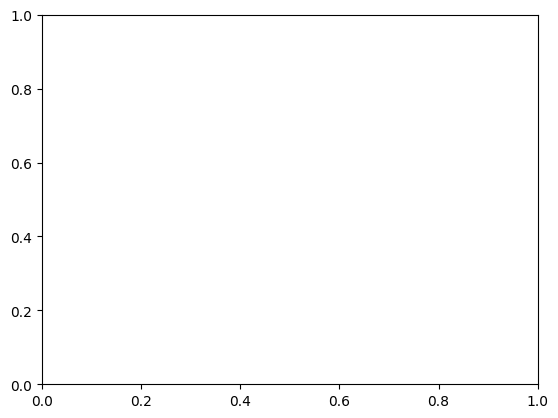

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


# In[2]:


class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
#             nn.Sigmoid()
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):


        s1 = self.model(input_1)
        s2 = self.model(input_2)

        out = self.output_sig(s1-s2)

        return out

    def predict(self, input_):

        s = self.model(input_)
        return s


# In[12]:


n_sample = 30000
n_feature = 300
data1 = torch.rand((n_sample,n_feature))
data2 = torch.rand((n_sample, n_feature))

y = np.random.random(( n_sample,1))
y = y > 0.9
y = 1. * y
y = torch.Tensor(y)

rank_model = RankNet(num_feature=n_feature)
optimizer = torch.optim.Adam(rank_model.parameters())

loss_fun = torch.nn.BCELoss()

rank_model.cuda()
# optimizer.cuda()
loss_fun.cuda()

data1 = data1.cuda()
data2 = data2.cuda()

y = y.cuda()


# In[13]:


epoch = 20000

losses = []

for i in range(epoch):

    rank_model.zero_grad()

    y_pred = rank_model(data1, data2)

    loss = loss_fun(y_pred,y)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if i % 500 == 0:

        print('Epoch{}, loss : {}'.format(i, loss.item()))




# In[6]:


import matplotlib.pyplot as plt


# In[7]:


x = list(range(10000))


# In[11]:


plt.plot(x, losses)